## Week 5 Deep Learning: *I Am Something of a Painter Myself* with GANs

### Overview

For this week's project challenge, we’ve been assigned a task via Kaggle's *"I Am Something of a Painter Myself"* competition: to generate a set of painting-style images from regular photographs — images convincing enough to potentially fool a museum into believing they were painted by Claude Monet.

For training, we are provided with two datasets:
- A collection of Claude Monet paintings
- A collection of real landscape photographs

These form the foundation of this week’s deep learning project.



#### What Unique Challenges Exist for This Deep Learning Project Compared to Prior Weeks?

Unlike earlier projects, this week’s task involves Generative Adversarial Networks (GANs). GANs consist of two models:
- A Generator: attempts to create realistic Monet-style images
- A Discriminator: tries to distinguish between real Monet paintings and the generator's output

The two models are trained in opposition — the generator improves by "fooling" the discriminator, while the discriminator gets better at spotting fakes. Their interplay is governed by loss functions, which in turn are optimized using gradient-based methods (something we’ve become familiar with in prior weeks).



#### How Do the Generator and Discriminator Work Together?

We can think of the generator as initially producing outputs from random noise. Over time, it learns to generate Monet-style images by:
- Deconstructing input photos
- Encoding important features
- Reconstructing images that resemble Monet’s style

Meanwhile, the discriminator evaluates how close the generator's output is to the real Monet paintings. Loss functions measure the difference between generated images and authentic paintings. These losses guide the training of both models through backpropagation and optimization.



#### Why Use CycleGAN?

In this project, I’ll focus on a specific type of GAN known as a CycleGAN, particularly suited for artistic style transfer. While I reference Amy Jang’s CycleGAN tutorial on Kaggle ([link](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial)), I also introduce an architectural enhancement using Residual Networks (ResNet).

This distinguishes our implementation from Amy Jang’s, by incorporating residual blocks in the generator network.



#### What Are Residual Blocks, and Why Are They Useful?

Unlike simple encoder-decoder models (which compress and then reconstruct features), Residual Blocks allow the network to preserve original input features through skip connections.

Benefits of residual blocks include:
- Keeping spatial and texture information intact  
- Learning only delta-style edits (i.e., what to change, not recreate)
- Strong performance on unpaired image translation (like photo ↔ Monet)
- More stable training compared to vanilla GANs

They form the backbone of our generator and are a key reason ResNet-based CycleGANs outperform simpler architectures.


#### Why Use PatchGAN as the Discriminator?

Instead of evaluating an entire image globally, PatchGAN looks at local patches — for example, 70x70 regions of the image — and determines whether each patch is "real" or "fake."

This is particularly effective for style transfer tasks like ours. That’s because:
-  Monet’s style is defined more by local brushstroke texture than overall structure
-  Classic Monet traits (short, quick strokes, translucent layers, complex color blending) appear at the patch level
-  Patch-level discrimination is more efficient and less computationally intensive than full-image evaluation



#### Wrapping Up This Introduction

While I’ll provide more details on the CycleGAN architecture and training strategy later in the notebook, this overview should give a sense of the deep learning techniques powering this project.

Now, let's dive into the implementation.


In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        print(e)


2025-04-07 12:50:37.077045: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 12:50:37.321151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744048237.390771  314579 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744048237.411365  314579 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744048237.576550  314579 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Memory growth enabled


In [2]:
# 📦 Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm

In [3]:
data_dir = './data'  # or wherever you unzipped it

for root, dirs, files in os.walk(data_dir):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {len(files)} files")
    break  # just top level

Directory: ./data
Subdirectories: ['photo_tfrec', '.ipynb_checkpoints', 'monet_tfrec', 'photo_jpg', 'monet_jpg']
Files: 2 files


In [12]:
import os
import glob

def count_images(folder_path, ext="jpg"):
    return len(glob.glob(os.path.join(folder_path, f"*.{ext}")))

monet_count = count_images('./data/monet_jpg')
photo_count = count_images('./data/photo_jpg')

print(f"Monet images: {monet_count}")
print(f"Photo images: {photo_count}")


Monet images: 300
Photo images: 7038


Here are some sample photos from the Monet folder of images.  Probably one of the more complex feature of the Monet 

painting that could be arguable difficult to replicate is Monet's specular vibrance at times.  Specularity refers to 

the bright, shiny reflections you see on a surface when it's directly illuminated by a light source.  You can see this light

vibrance below in some of the Monet images that are generally either full sun or partially cloudy days.  Compare to other weather 

conditions that are dreary.  Monet's paintings look more muted!  Specularity in Monet's painting, we would note add finer contrasting 

light details!  It might be worth adding a loss function for specularity?  As it turns out we may focus on both directional edges and 

non-directional edges (using sobel functions) to preserve specular highlights.

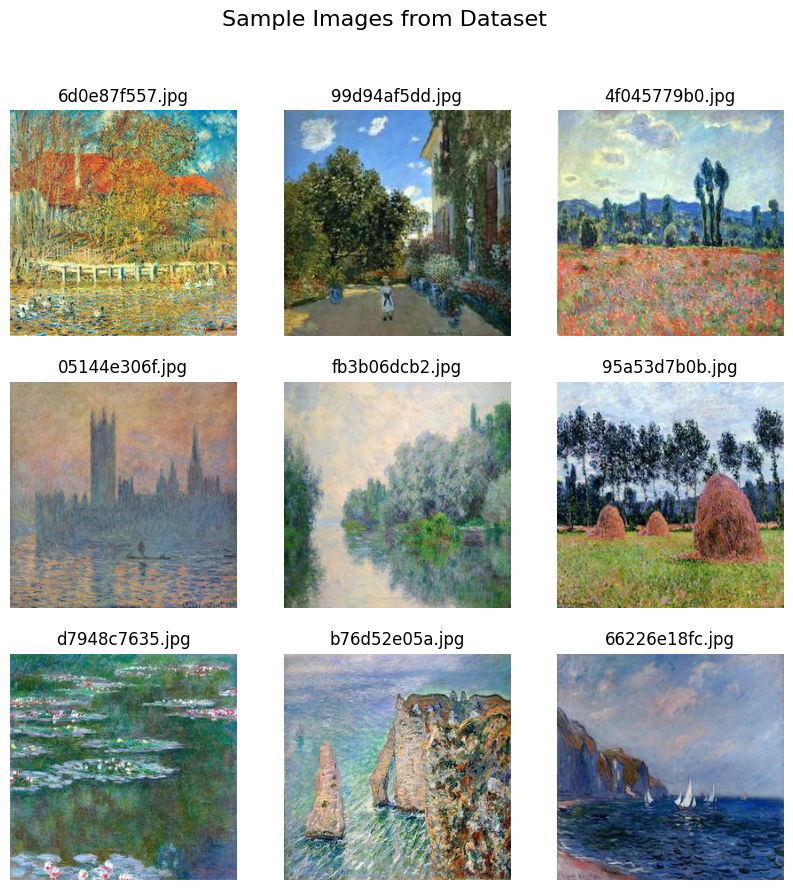

In [3]:
import random

image_folder = os.path.join(data_dir, "monet_jpg")  

sample_images = random.sample(os.listdir(image_folder), 9)

plt.figure(figsize=(10, 10))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_name)
    img = Image.open(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.show()

Water landscape images tend to have cooler tonality (i.e., blue spectrum predominance).  While Monet, has water scenes above that demonstrate similar tonality to some of the images below.  We might notice the Monet image of the ships at see above have quite a bit of blue contrast (i.e., between light and dark ranges of blue).  Compare the shoreline images that have more surface water reflection (i.e., there is less water turbulence).  Blue contrast in the photographic images below have a shallower range in one photo, and a deeper range in another, but notice the warm reflection of autumn trees.  The autumn water landscape picture (shown upper left) has deeper light contrast in the lower left regions of the image.  The center shoreline image seems like it could already have some impressionistic attributes with long exposure capture and deep light contrasts.  Although when we see the Monet images above, it appears that Monet may not have been as interested purely in Golden Hour lighting conditions when thinking of his compositions.

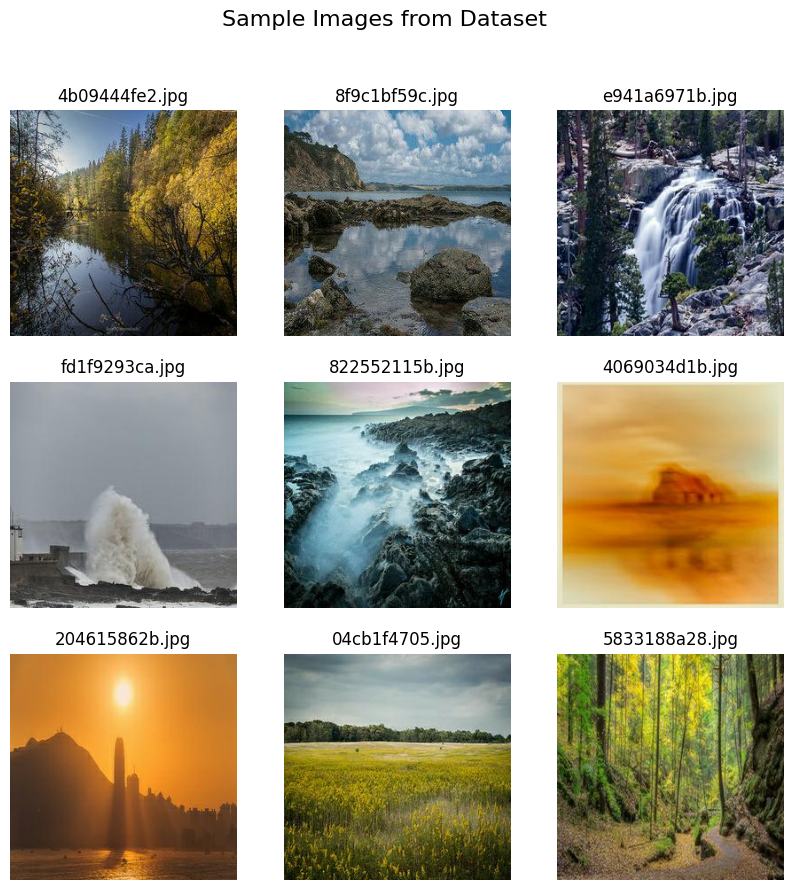

In [13]:
import random

image_folder = os.path.join(data_dir, "photo_jpg")  

sample_images = random.sample(os.listdir(image_folder), 9)

plt.figure(figsize=(10, 10))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_name)
    img = Image.open(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]

<Axes: title={'center': 'Image Color Modes'}>

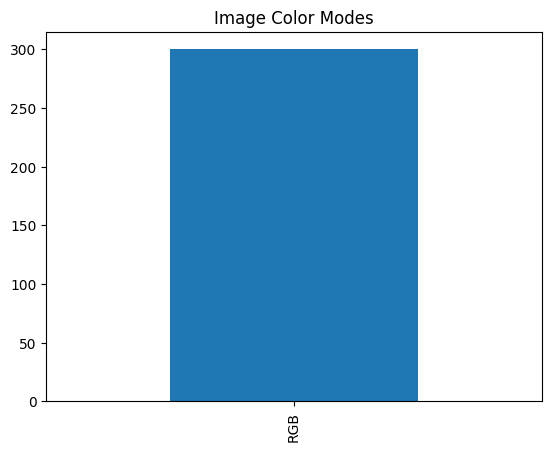

In [4]:
modes = []
for img_name in tqdm(os.listdir(image_folder)[:500]):
    img_path = os.path.join(image_folder, img_name)
    with Image.open(img_path) as img:
        modes.append(img.mode)

pd.Series(modes).value_counts().plot(kind="bar", title="Image Color Modes")

A reading of the histograms below indicate that with blue means more spread out, while green is less variable on the correlation say with red tells us that we have warmer color image tones.  Warm tones are typically more green-red or (yellow in tone).  Cool toned photography is more blue predominant.  Typically landscape photography are in warmer tonal ranges.  Because this is in our photo folder (not the monet folder), the photo dataset should translate better stylistically for Monet's warmer tonal range.

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 1.02, 'RGB Mean Distributions')

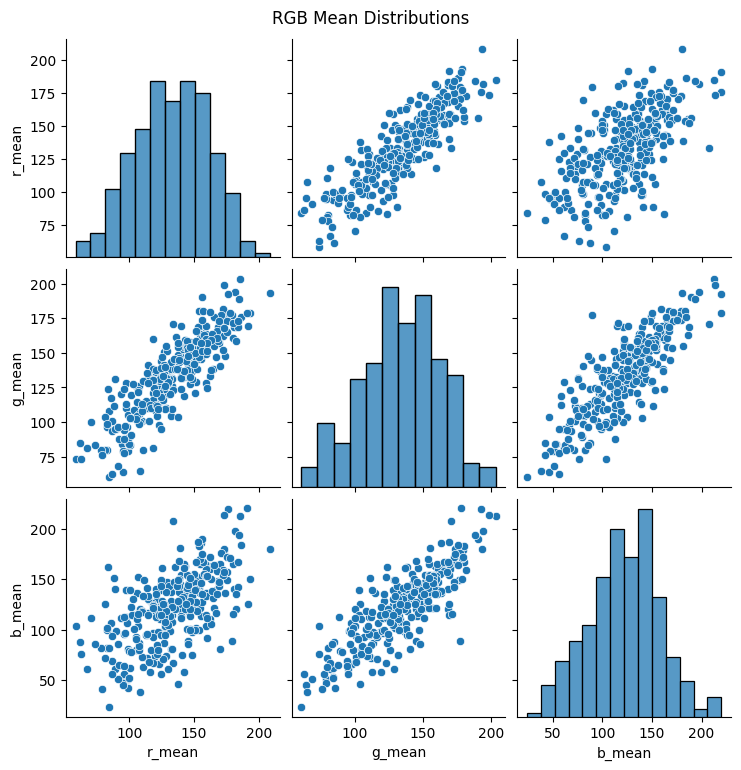

In [5]:
def get_color_histogram(img_path):
    img = Image.open(img_path).resize((64, 64)).convert("RGB")
    r, g, b = img.split()
    return {
        'r_mean': np.mean(r),
        'g_mean': np.mean(g),
        'b_mean': np.mean(b)
    }

color_data = []
for img_name in tqdm(os.listdir(image_folder)[:500]):
    img_path = os.path.join(image_folder, img_name)
    color_data.append(get_color_histogram(img_path))

color_df = pd.DataFrame(color_data)
sns.pairplot(color_df)
plt.suptitle("RGB Mean Distributions", y=1.02)

A low entropy < 14 tell us that images are not so complex and easier to train.  High entropy +15 >  tell us that the image

is more difficult to train.

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Image Complexity (Entropy)')

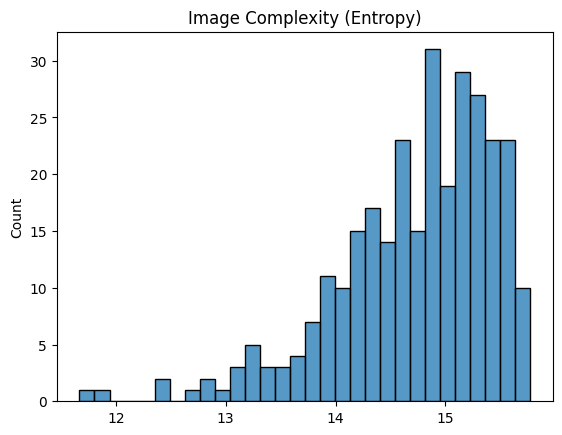

In [7]:
from skimage.measure import shannon_entropy
from skimage.io import imread

entropy_scores = []
for img_name in tqdm(os.listdir(image_folder)[:500]):
    img_path = os.path.join(image_folder, img_name)
    img = imread(img_path, as_gray=True)
    entropy_scores.append(shannon_entropy(img))

sns.histplot(entropy_scores, bins=30)
plt.title("Image Complexity (Entropy)")

#### What does t-SNE analysis tell us below?  

The domain space between Monet and photograph images are not easily separable (as visually seen in the graph below).  That is, there isn't any distinct grouping of Monet images relative the domain of non-Monet images.  This has other implications as well.  Namely, we aren't likely to find GAN architecture that is domain generalized across the image very useful for learning well Monet's stylistic features.  This is important since this fits well into patchGAN discriminator architecture.  We are looking for localized stylistic subtelties in the Monet stylistic transfer training case.  Again, we are not interested in global content for a given Monet training image. 

  0%|                                                               | 0/200 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1743982962.739495  201758 service.cc:152] XLA service 0x7fe5b9320de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743982962.742671  201758 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-04-06 18:42:42.856171: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1743982964.501228  201758 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
  0%|▎                                                      | 1/200 [00:02<06:58,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|█                                                      | 4/200 [00:02<01:25,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|█▉                                                     | 7/200 [00:02<00:44,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|██▋                                                   | 10/200 [00:02<00:28,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|███▌                                                  | 13/200 [00:02<00:20,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|████▎                                                 | 16/200 [00:02<00:16, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█████▏                                                | 19/200 [00:02<00:13, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|█████▉                                                | 22/200 [00:03<00:11, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|██████▊                                               | 25/200 [00:03<00:10, 17.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|███████▌                                              | 28/200 [00:03<00:09, 18.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|████████▎                                             | 31/200 [00:03<00:08, 19.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█████████▏                                            | 34/200 [00:03<00:08, 20.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█████████▉                                            | 37/200 [00:03<00:07, 20.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██████████▊                                           | 40/200 [00:03<00:07, 20.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|███████████▌                                          | 43/200 [00:04<00:07, 20.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|████████████▍                                         | 46/200 [00:04<00:07, 21.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|█████████████▏                                        | 49/200 [00:04<00:07, 20.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██████████████                                        | 52/200 [00:04<00:07, 20.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██████████████▊                                       | 55/200 [00:04<00:07, 20.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|███████████████▋                                      | 58/200 [00:04<00:06, 20.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 30%|████████████████▍                                     | 61/200 [00:04<00:06, 20.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 32%|█████████████████▎                                    | 64/200 [00:05<00:06, 20.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 34%|██████████████████                                    | 67/200 [00:05<00:06, 20.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 35%|██████████████████▉                                   | 70/200 [00:05<00:06, 20.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 36%|███████████████████▋                                  | 73/200 [00:05<00:06, 20.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 38%|████████████████████▌                                 | 76/200 [00:05<00:06, 20.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 40%|█████████████████████▎                                | 79/200 [00:05<00:05, 20.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 41%|██████████████████████▏                               | 82/200 [00:05<00:05, 20.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 42%|██████████████████████▉                               | 85/200 [00:06<00:05, 20.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 44%|███████████████████████▊                              | 88/200 [00:06<00:05, 20.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 46%|████████████████████████▌                             | 91/200 [00:06<00:05, 20.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 47%|█████████████████████████▍                            | 94/200 [00:06<00:05, 20.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 48%|██████████████████████████▏                           | 97/200 [00:06<00:05, 20.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 50%|██████████████████████████▌                          | 100/200 [00:06<00:04, 20.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 52%|███████████████████████████▎                         | 103/200 [00:06<00:04, 20.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 53%|████████████████████████████                         | 106/200 [00:07<00:04, 20.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 55%|████████████████████████████▉                        | 109/200 [00:07<00:04, 20.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 56%|█████████████████████████████▋                       | 112/200 [00:07<00:04, 20.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|██████████████████████████████▍                      | 115/200 [00:07<00:04, 19.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|███████████████████████████████                      | 117/200 [00:07<00:04, 18.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|███████████████████████████████▌                     | 119/200 [00:07<00:04, 16.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|████████████████████████████████                     | 121/200 [00:07<00:04, 16.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|████████████████████████████████▌                    | 123/200 [00:08<00:04, 16.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 62%|█████████████████████████████████▏                   | 125/200 [00:08<00:04, 17.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 64%|█████████████████████████████████▋                   | 127/200 [00:08<00:04, 17.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 64%|██████████████████████████████████▏                  | 129/200 [00:08<00:03, 18.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████████████████████████████████▋                  | 131/200 [00:08<00:03, 18.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|███████████████████████████████████▏                 | 133/200 [00:08<00:03, 18.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 68%|███████████████████████████████████▊                 | 135/200 [00:08<00:03, 18.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|████████████████████████████████████▎                | 137/200 [00:08<00:03, 18.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|████████████████████████████████████▊                | 139/200 [00:08<00:03, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|█████████████████████████████████████▎               | 141/200 [00:09<00:03, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|█████████████████████████████████████▉               | 143/200 [00:09<00:03, 17.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|██████████████████████████████████████▍              | 145/200 [00:09<00:03, 17.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|██████████████████████████████████████▉              | 147/200 [00:09<00:03, 17.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████████████████████████████████████▍             | 149/200 [00:09<00:02, 17.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|████████████████████████████████████████             | 151/200 [00:09<00:02, 17.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|████████████████████████████████████████▌            | 153/200 [00:09<00:02, 16.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|█████████████████████████████████████████            | 155/200 [00:09<00:02, 17.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|█████████████████████████████████████████▌           | 157/200 [00:10<00:02, 17.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|██████████████████████████████████████████▏          | 159/200 [00:10<00:02, 17.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|██████████████████████████████████████████▋          | 161/200 [00:10<00:02, 17.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|███████████████████████████████████████████▏         | 163/200 [00:10<00:02, 17.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|███████████████████████████████████████████▋         | 165/200 [00:10<00:02, 17.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████████████████████████████████████████▎        | 167/200 [00:10<00:02, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 84%|████████████████████████████████████████████▊        | 169/200 [00:10<00:02, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|█████████████████████████████████████████████▎       | 171/200 [00:10<00:01, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|█████████████████████████████████████████████▊       | 173/200 [00:11<00:01, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|██████████████████████████████████████████████▍      | 175/200 [00:11<00:01, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|██████████████████████████████████████████████▉      | 177/200 [00:11<00:01, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|███████████████████████████████████████████████▍     | 179/200 [00:11<00:01, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 90%|███████████████████████████████████████████████▉     | 181/200 [00:11<00:01, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|████████████████████████████████████████████████▍    | 183/200 [00:11<00:01, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████████████████████████████████████████████    | 185/200 [00:11<00:01, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████████████████████████████████████████████▌   | 187/200 [00:12<00:00, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|██████████████████████████████████████████████████   | 189/200 [00:12<00:00, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|██████████████████████████████████████████████████▌  | 191/200 [00:12<00:00, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|███████████████████████████████████████████████████▏ | 193/200 [00:12<00:00, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 98%|███████████████████████████████████████████████████▋ | 195/200 [00:12<00:00, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|████████████████████████████████████████████████████▏| 197/200 [00:12<00:00, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|████████████████████████████████████████████████████▋| 199/200 [00:12<00:00, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|                                                               | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  1%|▌                                                      | 2/200 [00:00<00:13, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|█                                                      | 4/200 [00:00<00:13, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|█▋                                                     | 6/200 [00:00<00:13, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|██▏                                                    | 8/200 [00:00<00:13, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|██▋                                                   | 10/200 [00:00<00:13, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|███▏                                                  | 12/200 [00:00<00:13, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|███▊                                                  | 14/200 [00:00<00:12, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|████▎                                                 | 16/200 [00:01<00:12, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  9%|████▊                                                 | 18/200 [00:01<00:12, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|█████▍                                                | 20/200 [00:01<00:12, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 11%|█████▉                                                | 22/200 [00:01<00:13, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|██████▍                                               | 24/200 [00:01<00:15, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|███████                                               | 26/200 [00:01<00:13, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|███████▌                                              | 28/200 [00:02<00:13, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|████████                                              | 30/200 [00:02<00:12, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|████████▋                                             | 32/200 [00:02<00:12, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█████████▏                                            | 34/200 [00:02<00:11, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█████████▋                                            | 36/200 [00:02<00:11, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 19%|██████████▎                                           | 38/200 [00:02<00:13, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|██████████▊                                           | 40/200 [00:02<00:13, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|███████████▎                                          | 42/200 [00:03<00:12, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|███████████▉                                          | 44/200 [00:03<00:11, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|████████████▍                                         | 46/200 [00:03<00:10, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|████████████▉                                         | 48/200 [00:03<00:10, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|█████████████▌                                        | 50/200 [00:03<00:10, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██████████████                                        | 52/200 [00:03<00:10, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██████████████▌                                       | 54/200 [00:03<00:09, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|███████████████                                       | 56/200 [00:04<00:09, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|███████████████▋                                      | 58/200 [00:04<00:09, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|████████████████▏                                     | 60/200 [00:04<00:09, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 31%|████████████████▋                                     | 62/200 [00:04<00:10, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 32%|█████████████████▎                                    | 64/200 [00:04<00:10, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|█████████████████▊                                    | 66/200 [00:04<00:09, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 34%|██████████████████▎                                   | 68/200 [00:04<00:09, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|██████████████████▉                                   | 70/200 [00:05<00:09, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███████████████████▍                                  | 72/200 [00:05<00:08, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 37%|███████████████████▉                                  | 74/200 [00:05<00:09, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 38%|████████████████████▌                                 | 76/200 [00:05<00:09, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|█████████████████████                                 | 78/200 [00:05<00:08, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|█████████████████████▌                                | 80/200 [00:05<00:08, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 41%|██████████████████████▏                               | 82/200 [00:05<00:08, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|██████████████████████▋                               | 84/200 [00:06<00:08, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|███████████████████████▏                              | 86/200 [00:06<00:08, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|███████████████████████▊                              | 88/200 [00:06<00:08, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████████████████████████▎                             | 90/200 [00:06<00:08, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 46%|████████████████████████▊                             | 92/200 [00:06<00:07, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 47%|█████████████████████████▍                            | 94/200 [00:06<00:08, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|█████████████████████████▉                            | 96/200 [00:06<00:07, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 49%|██████████████████████████▍                           | 98/200 [00:07<00:07, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|██████████████████████████▌                          | 100/200 [00:07<00:07, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|███████████████████████████                          | 102/200 [00:07<00:07, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 52%|███████████████████████████▌                         | 104/200 [00:07<00:07, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|████████████████████████████                         | 106/200 [00:07<00:07, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|████████████████████████████▌                        | 108/200 [00:07<00:06, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 55%|█████████████████████████████▏                       | 110/200 [00:07<00:06, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 56%|█████████████████████████████▋                       | 112/200 [00:08<00:06, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|██████████████████████████████▏                      | 114/200 [00:08<00:06, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 58%|██████████████████████████████▋                      | 116/200 [00:08<00:06, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|███████████████████████████████▎                     | 118/200 [00:08<00:06, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|███████████████████████████████▊                     | 120/200 [00:08<00:05, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 61%|████████████████████████████████▎                    | 122/200 [00:08<00:05, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 62%|████████████████████████████████▊                    | 124/200 [00:09<00:05, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|█████████████████████████████████▍                   | 126/200 [00:09<00:05, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 64%|█████████████████████████████████▉                   | 128/200 [00:09<00:05, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 65%|██████████████████████████████████▍                  | 130/200 [00:09<00:05, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|██████████████████████████████████▉                  | 132/200 [00:09<00:04, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 67%|███████████████████████████████████▌                 | 134/200 [00:09<00:04, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 68%|████████████████████████████████████                 | 136/200 [00:09<00:04, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|████████████████████████████████████▌                | 138/200 [00:10<00:04, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|█████████████████████████████████████                | 140/200 [00:10<00:04, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|█████████████████████████████████████▋               | 142/200 [00:10<00:04, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|██████████████████████████████████████▏              | 144/200 [00:10<00:04, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|██████████████████████████████████████▋              | 146/200 [00:10<00:04, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████████████████████████████████████▏             | 148/200 [00:10<00:03, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████████████████████████████████████▊             | 150/200 [00:10<00:03, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|████████████████████████████████████████▎            | 152/200 [00:11<00:03, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|████████████████████████████████████████▊            | 154/200 [00:11<00:03, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|█████████████████████████████████████████▎           | 156/200 [00:11<00:03, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|█████████████████████████████████████████▊           | 158/200 [00:11<00:03, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|██████████████████████████████████████████▍          | 160/200 [00:11<00:03, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|██████████████████████████████████████████▉          | 162/200 [00:11<00:02, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|███████████████████████████████████████████▍         | 164/200 [00:11<00:02, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 83%|███████████████████████████████████████████▉         | 166/200 [00:12<00:02, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████████████████████████████████████████▌        | 168/200 [00:12<00:02, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|█████████████████████████████████████████████        | 170/200 [00:12<00:02, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|█████████████████████████████████████████████▌       | 172/200 [00:12<00:02, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 87%|██████████████████████████████████████████████       | 174/200 [00:12<00:02, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|██████████████████████████████████████████████▋      | 176/200 [00:12<00:01, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 89%|███████████████████████████████████████████████▏     | 178/200 [00:13<00:01, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|███████████████████████████████████████████████▋     | 180/200 [00:13<00:01, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 91%|████████████████████████████████████████████████▏    | 182/200 [00:13<00:01, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|████████████████████████████████████████████████▊    | 184/200 [00:13<00:01, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 93%|█████████████████████████████████████████████████▎   | 186/200 [00:13<00:01, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████████████████████████████████████████████▊   | 188/200 [00:13<00:00, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 95%|██████████████████████████████████████████████████▎  | 190/200 [00:14<00:00, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|██████████████████████████████████████████████████▉  | 192/200 [00:14<00:00, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|███████████████████████████████████████████████████▍ | 194/200 [00:14<00:00, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|███████████████████████████████████████████████████▉ | 196/200 [00:14<00:00, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 99%|████████████████████████████████████████████████████▍| 198/200 [00:14<00:00, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.47it/s]


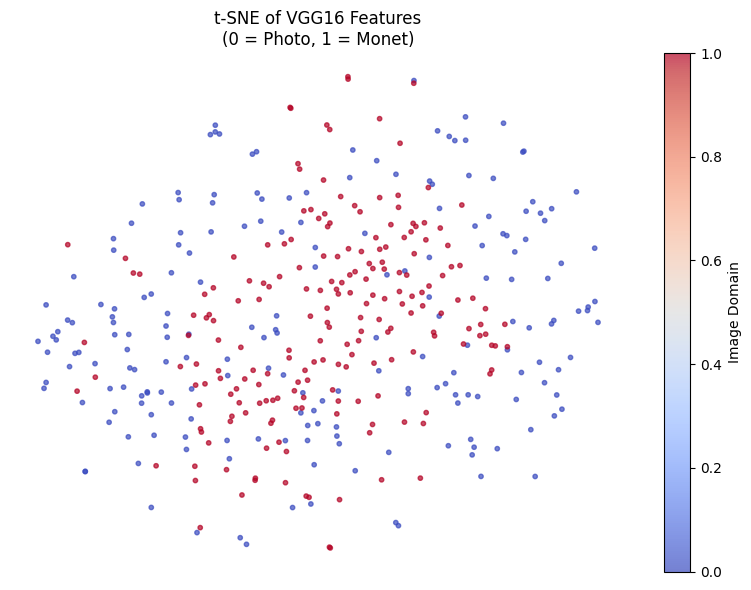

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.manifold import TSNE

# Load VGG16 model (no top, feature extractor)
model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

features = []
labels = []
data_dir='./data'
# Folder 1: Real photos
photo_folder = os.path.join(data_dir, "photo_jpg")
for img_name in tqdm(os.listdir(photo_folder)[:200]):
    img_path = os.path.join(photo_folder, img_name)
    img = load_img(img_path, target_size=(64, 64))
    img_arr = preprocess_input(np.expand_dims(img_to_array(img), axis=0))
    feat = model.predict(img_arr)
    features.append(feat.flatten())
    labels.append(0)  # Label: 0 = photo

# Folder 2: Monet paintings
monet_folder = os.path.join(data_dir, "monet_jpg")
for img_name in tqdm(os.listdir(monet_folder)[:200]):
    img_path = os.path.join(monet_folder, img_name)
    img = load_img(img_path, target_size=(64, 64))
    img_arr = preprocess_input(np.expand_dims(img_to_array(img), axis=0))
    feat = model.predict(img_arr)
    features.append(feat.flatten())
    labels.append(1)  # Label: 1 = Monet

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(features)

# Plot with color-coded labels
plt.figure(figsize=(8, 6))
plt.scatter(
    tsne_features[:, 0],
    tsne_features[:, 1],
    c=labels,
    cmap="coolwarm",
    s=10,
    alpha=0.7
)
plt.title("t-SNE of VGG16 Features\n(0 = Photo, 1 = Monet)")
plt.colorbar(label="Image Domain")
plt.axis("off")
plt.tight_layout()
plt.show()



This is a clean and well curated dataset.

In [11]:
# Option: use perceptual hash (pHash) to find near-duplicates
from PIL import Image
import imagehash

hashes = {}
duplicates = []

for img_name in tqdm(os.listdir(image_folder)):
    img_path = os.path.join(image_folder, img_name)
    img = Image.open(img_path)
    h = imagehash.phash(img)
    if h in hashes:
        duplicates.append((img_name, hashes[h]))
    else:
        hashes[h] = img_name

print(f"Found {len(duplicates)} potential duplicates.")

  0%|          | 0/300 [00:00<?, ?it/s]

Found 0 potential duplicates.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from glob import glob
from PIL import Image


For this project, I am running on my local machine without the aid of TPU, and because the cycleGAN architecture is more complex than very basic implementations, one has to be mindful of limited memory.  My GPU is limited 8Gb, so I've opted to restrict BATCH_SIZE to 1 for now. I am also creating the dataset from the images directly and not using the supplied datasets.  Batch processing is a common way to avoid memory related issues.

In [6]:
IMG_SIZE = 256
BATCH_SIZE = 1
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
def save_image(img_tensor, save_path):
    img = (img_tensor + 1.0) * 127.5  # Denormalize to [0, 255]
    img = tf.cast(img, tf.uint8)
    img = tf.image.encode_jpeg(img)
    tf.io.write_file(save_path, img)


In [8]:
def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img / 127.5) - 1.0
    return img

def create_dataset(path, batch_size=1):
    files = tf.data.Dataset.list_files(path + '/*.jpg')
    dataset = files.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()  # 🔥 Add this
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


photo_ds = create_dataset('./data/photo_jpg', batch_size=BATCH_SIZE)
monet_ds = create_dataset('./data/monet_jpg', batch_size=BATCH_SIZE)


## Generator Architecture (ResNet-based) 

The generator in this model is designed to transform input images into Monet-style paintings using a ResNet-based architecture. It takes a 256×256 RGB image as input and outputs a stylized image of the same dimensions. The architecture is composed of several key parts: initial feature extraction, downsampling, residual blocks, upsampling, and output reconstruction.

The process begins with a 7×7 convolutional layer, which captures broad visual patterns in the input image. This is followed by two downsampling layers using 3×3 convolutions with a stride of 2, reducing the image size to 64×64 while increasing the number of feature channels. This allows the network to learn more abstract features at a smaller scale.

Next, the model applies a series of residual blocks (typically 9), which help preserve the original content and structure of the input image while learning how to apply stylistic changes. Each residual block includes two convolutional layers and a skip connection that adds the input of the block to its output, enabling the model to focus on learning small differences rather than reconstructing the entire image from scratch.

After the residual blocks, two upsampling layers are used to restore the original image size. These layers use transposed convolutions to increase the spatial dimensions back to 128×128 and then to 256×256, gradually reconstructing the final image in the new artistic style.

Finally, the output layer is a 7×7 convolution with a `tanh` activation function, which maps pixel values to the range [-1, 1], matching the normalization typically used for GAN training. The result is a stylized image that retains the structure of the input but has been transformed to match the texture and color palette of Monet's paintings.


In [6]:
from tensorflow.keras import layers

def residual_block(x, filters):
    res = x
    x = layers.Conv2D(filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    return layers.add([x, res])

def build_generator(input_shape=(256, 256, 3), num_res_blocks=9):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution
    x = layers.Conv2D(64, kernel_size=7, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Downsampling
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    for _ in range(num_res_blocks):
        x = residual_block(x, 256)

    # Upsampling
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Final output layer
    x = layers.Conv2D(3, kernel_size=7, padding="same", activation="tanh")(x)

    return tf.keras.Model(inputs, x, name="generator")


## PatchGAN Discriminator

The discriminator in this model is based on a PatchGAN architecture, which differs from traditional discriminators by focusing on local image patches instead of the entire image. Rather than outputting a single scalar prediction (real or fake), PatchGAN outputs a grid of predictions, where each value corresponds to a small patch in the input image. This allows the model to assess the realism of local textures and patterns, which is particularly useful for style transfer tasks like generating Monet-style paintings.

The architecture starts with a 4×4 convolutional layer with a stride of 2, progressively reducing the spatial dimensions while increasing the depth of the feature maps. This is repeated across four convolutional blocks, each followed by LeakyReLU activation, and batch normalization in all but the first layer. The final convolutional layer outputs a single-channel feature map representing the authenticity of each image patch.

By evaluating overlapping 70×70 patches (determined by the kernel and stride configuration), the discriminator becomes highly sensitive to fine details, textures, and brushstrokes — which are essential for distinguishing real Monet paintings from generated ones. The result is a more localized and texture-aware evaluation, encouraging the generator to produce more realistic and stylistically consistent outputs.


In [7]:
def build_discriminator(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, kernel_size=4, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Output patch
    x = layers.Conv2D(1, kernel_size=4, strides=1, padding="same")(x)

    return tf.keras.Model(inputs, x, name="discriminator")


### Perceptual Loss Model

Here is a perceptual loss model to implement a perceptual loss function.

We will use this function to improve image realism, better preserve,

texture, style, and helping to reduce bluriness.  Immediate empirical results

from the loss function, incidentally range at around $10^2$ scaling.  We want 

this around $10^1$ ranges, so we can set our associated lambda parameter as needed

later.

In [8]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

# Create a VGG model for perceptual loss (use relu2_2 = 'block2_conv2')
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
perceptual_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block2_conv2').output)


### Building the models

In [14]:
G_photo_to_monet = build_generator(input_shape=(IMG_SIZE, IMG_SIZE, 3),num_res_blocks=6)
G_monet_to_photo = build_generator(input_shape=(IMG_SIZE, IMG_SIZE, 3),num_res_blocks=6)
D_photo = build_discriminator(input_shape=(IMG_SIZE, IMG_SIZE, 3))
D_monet = build_discriminator(input_shape=(IMG_SIZE, IMG_SIZE, 3))


### Defining Loss Functions

We will use loss functions with both buidling generator and discriminators in the cycleGAN implementation.  To do this,

we want loss function that promote realism, consistency, and finer detail in the generated images.  


- **Binary Cross Entropy** is designed to penalize heavily confident but incorrect prediction. It is used for binary tasks.

It is used in training the generator instance to fool the discriminator, and vice versa, train the discriminator to 

identify fakes.


- **GAN Loss function** is, as described in class, the minmax function where the Generator tries to minimize loss, whereas the 

discriminator tries to maximize loss.  GAN loss drives competition in the adversarial network in better training both

the generator and discriminator.


- **Cycle Consistency Loss** is aimed at improving the quality of the original image after the transformation from Photo to Monet, 

and Monet to Photo function models.  Ideally, a good Cycle consistency should return an image as close to the original under

a set of model of transformations.  Note:  Unlike Amy Jang's cycleGAN implementation, we are working bidirectionally 

and not unidirectionally.  This helps improve the quality of the unidirectional Photo to Monet transformation for such 

loss function.

- **Identity Loss** is used to help preserve content and color when such is in the target domain.  In otherwords,

If you feed a Monet painting into a generator that turns photos → Monets, it should ideally return the same painting without changing it.


- **Perceptual Loss** can be thought of a perception humanizing feature.  The idea is that model and loss function is looking at localities 

for texture and structure, but not at individual pixels.  Pixel based losses, for example, produce bluriness in the image, so Perceptual 

loss works to minimize bluriness of an image, for example. Increasing Perceptual loss parameter weighting to the upper ranges will 

remove banding and artifcats cleanly, but too much weighting means that perceptual loss predominates in the total loss function.

Its an empirical experimenting balancing act getting this lambda parametric setting right.  As mentioned before, loss in our context 

may scale range $10^2$.

-  **Edge Loss** in our instance is creates basic Sobel tensors and preserves both magnitude and directionality of image edges.  This

is to preserve more the image and reduce blurring tendancies, for example.

- **Edge loss preservation** is slightly mistitled as it is designed with light masking features.  This also extracts raw image sobel tensors

from both generator and original images, and works to preserve 'highlight' frequency related brightness.  If you examine, for example,

Monet's use of highlights in painting, you will find this creates a definition enhancing quality to his artistic renderings.  In essence,

we are trying to ensure we capture and more likely retain this stylistic feature which, at times, in painting produces slight glow and 

light shimmering effects.


In [22]:
# Binary cross-entropy for adversarial loss
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# GAN loss for generator (wants discriminator to predict "real" for generated images)
def generator_loss(fake_output):
    return loss_obj(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_labels = tf.ones_like(real_output) * tf.random.uniform([], 0.8, 1.0)  # smoothed labels
    fake_labels = tf.zeros_like(fake_output)
    
    real_loss = loss_obj(real_labels, real_output)
    fake_loss = loss_obj(fake_labels, fake_output)
    return (real_loss + fake_loss) * 0.5


# Cycle-consistency loss (L1 loss)
LAMBDA_CYCLE = 10.0

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA_CYCLE

# Identity loss (optional)
LAMBDA_ID = 5.0

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * LAMBDA_ID

def perceptual_loss(real, generated):
    # Scale to VGG input range
    real = preprocess_input((real + 1.0) * 127.5)
    generated = preprocess_input((generated + 1.0) * 127.5)

    real_features = perceptual_model(real)
    generated_features = perceptual_model(generated)

    return tf.reduce_mean(tf.abs(real_features - generated_features))

def edge_loss(real, generated):
    real_edges = tf.image.sobel_edges(real)
    gen_edges = tf.image.sobel_edges(generated)
    return tf.reduce_mean(tf.abs(real_edges - gen_edges))

def edge_preservation_loss(real, generated, brightness_threshold=0.6, epsilon=1e-6):

    """
    Weighted edge preservation loss focusing on bright areas in the image.
    """
    # Convert to [0, 1] to ensure Sobel edges are meaningful
    real_norm = tf.clip_by_value((real + 1.0) / 2.0, 0.0, 1.0)
    gen_norm = tf.clip_by_value((generated + 1.0) / 2.0, 0.0, 1.0)

    # Compute Sobel edges
    real_edges = tf.image.sobel_edges(real_norm)       # shape: [B, H, W, C, 2]
    gen_edges = tf.image.sobel_edges(gen_norm)

    # Compute L1 difference
    edge_diff = tf.abs(real_edges - gen_edges)         # shape: [B, H, W, C, 2]

    # Brightness (mean of channels) — shape: [B, H, W, 1]
    brightness = tf.reduce_mean(real_norm, axis=-1, keepdims=True)

    # Soft brightness weighting (optional: can use binary if preferred)
    brightness_weight = tf.clip_by_value((brightness - brightness_threshold), 0.0, 1.0) / (1.0 - brightness_threshold + epsilon)
    
    # Expand to match edge shape: [B, H, W, 1, 1]
    brightness_weight = tf.expand_dims(brightness_weight, axis=-1)

    # Apply weighting
    weighted_diff = edge_diff * brightness_weight

    return tf.reduce_mean(weighted_diff)






#### Combined Loss for each Generator

This demonstrate an example of how loss might be computed.  

We will actually see this in the training step below, however.

It isn't necessary to run the cell below.

In [17]:
total_loss_G_photo_to_monet = (
    generator_loss(fake_monet_output)
    + cycle_consistency_loss(real_photo, cycled_photo)
    + cycle_consistency_loss(real_monet, cycled_monet)
    + identity_loss(real_monet, same_monet)
)


NameError: name 'fake_monet_output' is not defined

### Full Train Step Function

The train_step function defines a single training iteration for the CycleGAN model. It begins by taking a batch 

of real images from two domains — typically, photos (real_photo) and artworks or styled images (real_monet). Using 

these, the function applies both generators: G_photo_to_monet converts real photos to Monet-style images 

(fake_monet), while G_monet_to_photo performs the reverse, generating photo-style images from Monet paintings 

(fake_photo). These generated images are then passed back through the opposite generators to produce cycled_photo 

and cycled_monet, which represent reconstructions of the original inputs. This enables the use of cycle consistency 

loss, which encourages the model to preserve the content and structure of the original images after a round-trip 

translation.

To further stabilize the mapping and maintain identity when translating an image already in the target domain, the 

model also computes identity mappings (same_photo, same_monet) and applies an identity loss. This helps preserve color 

and content consistency, preventing unnecessary alterations.

The function then uses the discriminators to evaluate both real and fake images in each domain. These evaluations produce 

predictions that are used to compute adversarial losses: the generator tries to fool the discriminator into thinking the

fake images are real, while the discriminator tries to correctly distinguish between real and generated samples. To 

improve stability and regularize the discriminator, label smoothing is applied to the real labels.

In addition to adversarial, cycle, and identity losses, the function can optionally incorporate more advanced losses like 

perceptual loss, which compares high-level feature representations from a pretrained VGG model, and edge-based losses 

(like Sobel or brightness-weighted edge loss), which enforce sharpness and structural fidelity in regions of visual importance.

After all losses are calculated, gradients are computed for both generators and discriminators using TensorFlow’s GradientTape. 

These gradients are then applied via their respective optimizers to update the model weights. The function returns a dictionary 

of the various loss components for monitoring and visualization during training.

In [29]:
# Create optimizers
generator_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:
        # Generate fakes
        fake_monet = G_photo_to_monet(real_photo, training=True)
        fake_photo = G_monet_to_photo(real_monet, training=True)

        # Cycled images
        cycled_photo = G_monet_to_photo(fake_monet, training=True)
        cycled_monet = G_photo_to_monet(fake_photo, training=True)

        # Identity (optional but helpful)
        same_photo = G_monet_to_photo(real_photo, training=True)
        same_monet = G_photo_to_monet(real_monet, training=True)

        # Discriminator outputs
        disc_real_photo = D_photo(real_photo, training=True)
        disc_real_monet = D_monet(real_monet, training=True)
        disc_fake_photo = D_photo(fake_photo, training=True)
        disc_fake_monet = D_monet(fake_monet, training=True)

        # Generator losses
        gen_G_loss = generator_loss(disc_fake_monet)
        gen_F_loss = generator_loss(disc_fake_photo)

        # Cycle losses
        cycle_loss_total = cycle_consistency_loss(real_photo, cycled_photo) + \
                           cycle_consistency_loss(real_monet, cycled_monet)

        # Identity losses
        id_loss_G = identity_loss(real_monet, same_monet)
        id_loss_F = identity_loss(real_photo, same_photo)

        # Perceptual loss (real vs fake)
        perc_loss_G = perceptual_loss(real_monet, fake_monet)
        perc_loss_F = perceptual_loss(real_photo, fake_photo)

        lambda_perc = 0.05  # You can adjust this for more or less emphasis

        # Edge loss (real vs fake)
        edge_loss_G = edge_loss(real_monet, fake_monet)
        edge_loss_F = edge_loss(real_photo, fake_photo)

        lambda_edge = 10.0

        # Edge preservation loss (real vs fake)
        edge_pres_loss_G = edge_preservation_loss(real_monet, fake_monet)
        edge_pres_loss_F = edge_preservation_loss(real_photo, fake_photo)

        lambda_edge_pres = 100.0

        # Total generator losses
        total_loss_G = gen_G_loss + cycle_loss_total + id_loss_G + lambda_perc * perc_loss_G + lambda_edge * edge_loss_G + lambda_edge_pres * edge_pres_loss_G
        total_loss_F = gen_F_loss + cycle_loss_total + id_loss_F + lambda_perc * perc_loss_F + lambda_edge * edge_loss_F + lambda_edge_pres * edge_pres_loss_F

        # Discriminator losses
        disc_loss_photo = discriminator_loss(disc_real_photo, disc_fake_photo)
        disc_loss_monet = discriminator_loss(disc_real_monet, disc_fake_monet)
  
    
    # Calculate gradients and apply
    generator_G_grads = tape.gradient(total_loss_G, G_photo_to_monet.trainable_variables)
    generator_F_grads = tape.gradient(total_loss_F, G_monet_to_photo.trainable_variables)

    discriminator_photo_grads = tape.gradient(disc_loss_photo, D_photo.trainable_variables)
    discriminator_monet_grads = tape.gradient(disc_loss_monet, D_monet.trainable_variables)

    generator_G_optimizer.apply_gradients(zip(generator_G_grads, G_photo_to_monet.trainable_variables))
    generator_F_optimizer.apply_gradients(zip(generator_F_grads, G_monet_to_photo.trainable_variables))

    discriminator_X_optimizer.apply_gradients(zip(discriminator_photo_grads, D_photo.trainable_variables))
    discriminator_Y_optimizer.apply_gradients(zip(discriminator_monet_grads, D_monet.trainable_variables))

    return {
        "gen_G": total_loss_G,
        "gen_F": total_loss_F,
        "disc_photo": disc_loss_photo,
        "disc_monet": disc_loss_monet,
        "cycle": cycle_loss_total,
        "id_G": id_loss_G,
        "id_F": id_loss_F,
        "perc_G": perc_loss_G,
        "perc_F": perc_loss_F,
        "edge_G": edge_loss_G,
        "edge_F": edge_loss_F,
        "edge_pres_G": edge_pres_loss_G,
        "edge_pres_F": edge_pres_loss_F

    }


The helper functions below will be useful in monitoring epoch training progress,

so that we can see a side-by-side comparison of input originals relative a fake monet

generated image.

In [41]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os

def denormalize(img):
    img = (img + 1.0) * 127.5
    return tf.cast(img, tf.uint8)

def generate_and_save_images(model, test_input, epoch, name='', save_dir='outputs'):
    prediction = model(test_input, training=False)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    plt.figure(figsize=(6, 3))

    # Original photo
    plt.subplot(1, 2, 1)
    plt.imshow(denormalize(test_input[0]).numpy())
    plt.title("Input Photo")
    plt.axis('off')

    # Generated Monet-style painting
    plt.subplot(1, 2, 2)
    plt.imshow(denormalize(prediction[0]).numpy())
    plt.title("Generated Monet")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"{save_dir}/epoch_{epoch:03d}{name}.png")
    plt.close()


Let's go ahead and revisit once more the number of images in either directory.

In [25]:
import glob

photo_paths = glob.glob('./data/photo_jpg/*.jpg')
monet_paths = glob.glob('./data/monet_jpg/*.jpg')

print(f"Photo images: {len(photo_paths)}")
print(f"Monet images: {len(monet_paths)}")


Photo images: 7038
Monet images: 300


### Train Images

This is a lengthier train on a modest lower level GPU that is CUDA enabled.

Plan for around a couple hours minimum (in my experience).

We are using 100 epochs, and combine the photo_ds (datset) and monet_ds to form 

the train_datset.  In monitoring performance we can watch for all of the loss 

function outputs.  Noting:  these loss computations are averaged per step per epoch.

We have set prediction image outputs for an original image every 5 epochs of completion.

In [30]:
EPOCHS = 100

train_dataset = tf.data.Dataset.zip((photo_ds, monet_ds))

steps_per_epoch = min(len(photo_paths), len(monet_paths)) // BATCH_SIZE

import time

for epoch in range(EPOCHS):
    print(f"\n🌀 Epoch {epoch+1}/{EPOCHS}")
    start = time.time()

    losses = {
        "gen_G": 0,
        "gen_F": 0,
        "disc_photo": 0,
        "disc_monet": 0,
        "cycle": 0,
        "id_G": 0,
        "id_F": 0,
        "perc_G": 0,
        "perc_F": 0,
        "edge_G": 0,
        "edge_F": 0,
        "edge_pres_G": 0,
        "edge_pres_F": 0
    }

    for step, (photo_batch, monet_batch) in enumerate(train_dataset):
        if step > steps_per_epoch:
            break

        loss_vals = train_step(photo_batch, monet_batch)

        for k in losses:
            losses[k] += loss_vals[k]

        if step % 100 == 0:
            print(f"  Step {step}/{steps_per_epoch}")

    # Average loss values
    for k in losses:
        losses[k] = losses[k] / steps_per_epoch
    sample_photo = next(iter(photo_ds.take(1)))
    if epoch % 5 == 0:
        generate_and_save_images(G_photo_to_monet, sample_photo, epoch)
    print(f"✅ Epoch {epoch+1} completed in {time.time() - start:.2f}s")
    print(f"  Generator G loss:      {losses['gen_G']:.4f}")
    print(f"  Generator F loss:      {losses['gen_F']:.4f}")
    print(f"  Discriminator Photo:   {losses['disc_photo']:.4f}")
    print(f"  Discriminator Monet:   {losses['disc_monet']:.4f}")
    print(f"  Cycle Consistency:     {losses['cycle']:.4f}")
    print(f"  Identity G/F:          {losses['id_G']:.4f} / {losses['id_F']:.4f}")
    print(f"  Perceptual Loss G:     {losses['perc_G']:.4f}")
    print(f"  Perceptual Loss F:     {losses['perc_F']:.4f}")
    print(f"  Edge Loss G:           {losses['edge_G']:.4f}")
    print(f"  Edge Loss F:           {losses['edge_F']:.4f}")
    print(f"  Edge Pres Loss G:      {losses['edge_pres_G']:.4f}")
    print(f"  Edge Pres Loss F:      {losses['edge_pres_F']:.4f}")




🌀 Epoch 1/100
  Step 0/300
  Step 100/300
  Step 200/300
  Step 300/300
✅ Epoch 1 completed in 107.23s
  Generator G loss:      22.9150
  Generator F loss:      21.3014
  Discriminator Photo:   0.4722
  Discriminator Monet:   0.4408
  Cycle Consistency:     6.2939
  Identity G/F:          1.4940 / 1.5166
  Perceptual Loss G:     122.5133
  Perceptual Loss F:     119.9672
  Edge Loss G:           0.4810
  Edge Loss F:           0.4255
  Edge Pres Loss G:      0.0202
  Edge Pres Loss F:      0.0136

🌀 Epoch 2/100
  Step 0/300
  Step 100/300
  Step 200/300
  Step 300/300
✅ Epoch 2 completed in 88.88s
  Generator G loss:      23.2433
  Generator F loss:      21.3050
  Discriminator Photo:   0.4709
  Discriminator Monet:   0.4335
  Cycle Consistency:     6.1454
  Identity G/F:          1.4466 / 1.4646
  Perceptual Loss G:     126.5892
  Perceptual Loss F:     122.1409
  Edge Loss G:           0.5012
  Edge Loss F:           0.4334
  Edge Pres Loss G:      0.0213
  Edge Pres Loss F:      0.

### Results

The graph below shows that Perceptual Loss—owing to its naturally higher scale—exhibits noticeable variation across epochs. 

Interestingly, the perceptual loss associated with the fake-relative photo domain (Generator F) shows slightly more cyclic 

variance compared to Generator G.

While Generator G's total loss demonstrates some longer-term dips, the variation is relatively small (under 5 units), 

suggesting limited movement. A similar trend is observed in Generator F’s total loss, indicating that the overall generator 

training remains balanced. However, neither generator shows a strong downward trend over time, implying that the models may 

have converged early into a local minimum, and that the adversarial component might not be providing a strong enough gradient 

signal to further refine the generators.

Despite the plateau in total generator loss, more granular inspection reveals subtle but meaningful shifts: identity losses for 

both G and F show gradual downward trends, and cycle consistency loss also exhibits a slow but steady decline. The discriminator 

losses for both photo and Monet domains follow a similar decreasing pattern, albeit on a smaller scale. In contrast, perceptual 

losses for both generators trend upward, which may indicate increasing feature-level divergence from the target domain despite 

apparent visual realism.

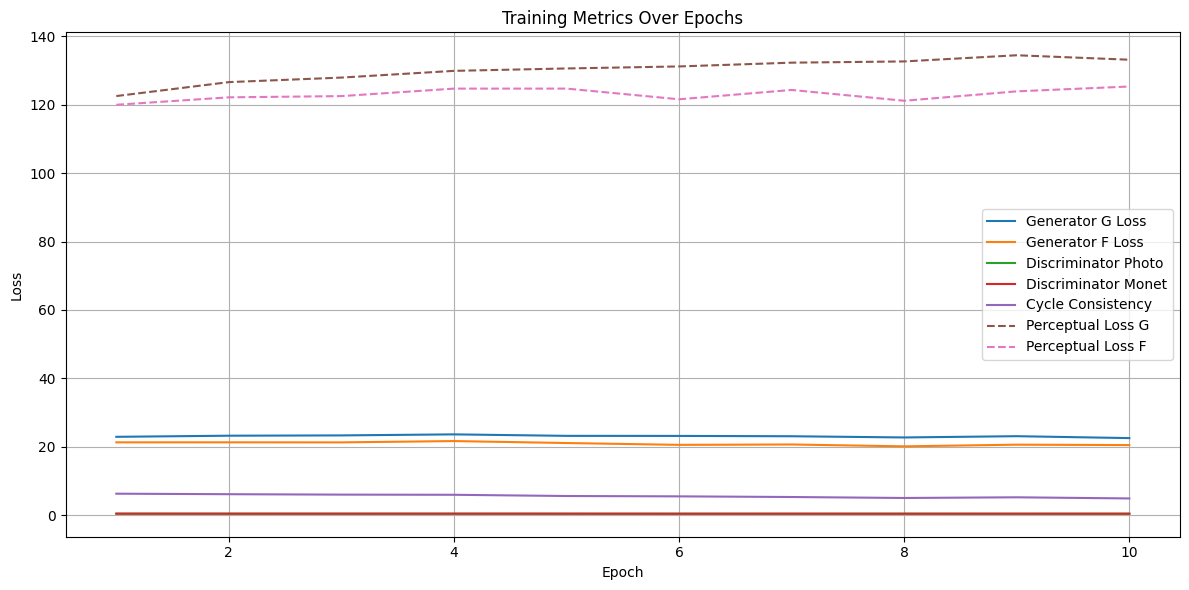

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# Simulated raw log string 
# Open and read the entire contents of the log.txt file
with open("log.txt", "r", encoding="utf-8") as file:
    log_text = file.read()

# Extract training metrics using regex
pattern = re.compile(
    r"Epoch (\d+) completed.*?Generator G loss:\s+([\d.]+).*?Generator F loss:\s+([\d.]+).*?"
    r"Discriminator Photo:\s+([\d.]+).*?Discriminator Monet:\s+([\d.]+).*?"
    r"Cycle Consistency:\s+([\d.]+).*?Identity G/F:\s+([\d.]+) / ([\d.]+).*?"
    r"Perceptual Loss G:\s+([\d.]+).*?Perceptual Loss F:\s+([\d.]+).*?"
    r"Edge Loss G:\s+([\d.]+).*?Edge Loss F:\s+([\d.]+).*?"
    r"Edge Pres Loss G:\s+([\d.]+).*?Edge Pres Loss F:\s+([\d.]+)",
    re.S
)

# Parse all epoch results
records = pattern.findall(log_text)
columns = [
    "Epoch", "Gen_G_Loss", "Gen_F_Loss", "Disc_Photo", "Disc_Monet",
    "Cycle_Cons", "Id_G", "Id_F", "Perc_G", "Perc_F", "Edge_G", "Edge_F", "Pres_G", "Pres_F"
]
df = pd.DataFrame(records, columns=columns).astype(float)

# Plot key losses
plt.figure(figsize=(12, 6))
plt.plot(df["Epoch"], df["Gen_G_Loss"], label="Generator G Loss")
plt.plot(df["Epoch"], df["Gen_F_Loss"], label="Generator F Loss")
plt.plot(df["Epoch"], df["Disc_Photo"], label="Discriminator Photo")
plt.plot(df["Epoch"], df["Disc_Monet"], label="Discriminator Monet")
plt.plot(df["Epoch"], df["Cycle_Cons"], label="Cycle Consistency")
plt.plot(df["Epoch"], df["Perc_G"], label="Perceptual Loss G", linestyle='--')
plt.plot(df["Epoch"], df["Perc_F"], label="Perceptual Loss F", linestyle='--')
plt.title("Training Metrics Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Let's go ahead and examine some sample predictions for the final training model

In [45]:
# Extract 10 unbatched individual images from the dataset
sample_photos = [image for image in photo_ds.unbatch().take(10)]
for i, sample_photo in enumerate(sample_photos):
    generate_and_save_images(G_photo_to_monet, tf.expand_dims(sample_photo, 0), 100, name=str(i), save_dir='outputs')


In [46]:
def load_images_from_directory(directory, prefix="epoch100", count=10):
    images = []
    for i in range(count):
        path = os.path.join(directory, f"{prefix}{i}.png")
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        images.append(img)
    return images


In [47]:
def display_image_grid(images, rows=2, cols=5, title="Generated Monet Images"):
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img.numpy())
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

### Results - Qualitative Observation analysis of Sample Images

We notice in the produced images below, that either images doesn't appear excessively blurred in the case of the Monet fake images.  

If we were to remove the Edge loss functions, we would more stongly see this feature in produced images.  However, Monet's expressive

stylizations are quite muted between image sets.  The overall appearance of these images appears as though a semi-translucent light mask

were applied giving a Matte like layered addition to each image. There isn't a degradation in the resolution of features (no obvious strong 

blurring signal), so we can reason that the edge loss functions have done their jobs!  Also the perceptual loss functions appear in these sets 

of images to have prevented artefacts and banding-like textural noise.  These usually show up like repeating textural bricks across an image

if present which can be evident for the basic cycleGAN implementations that I have seen.



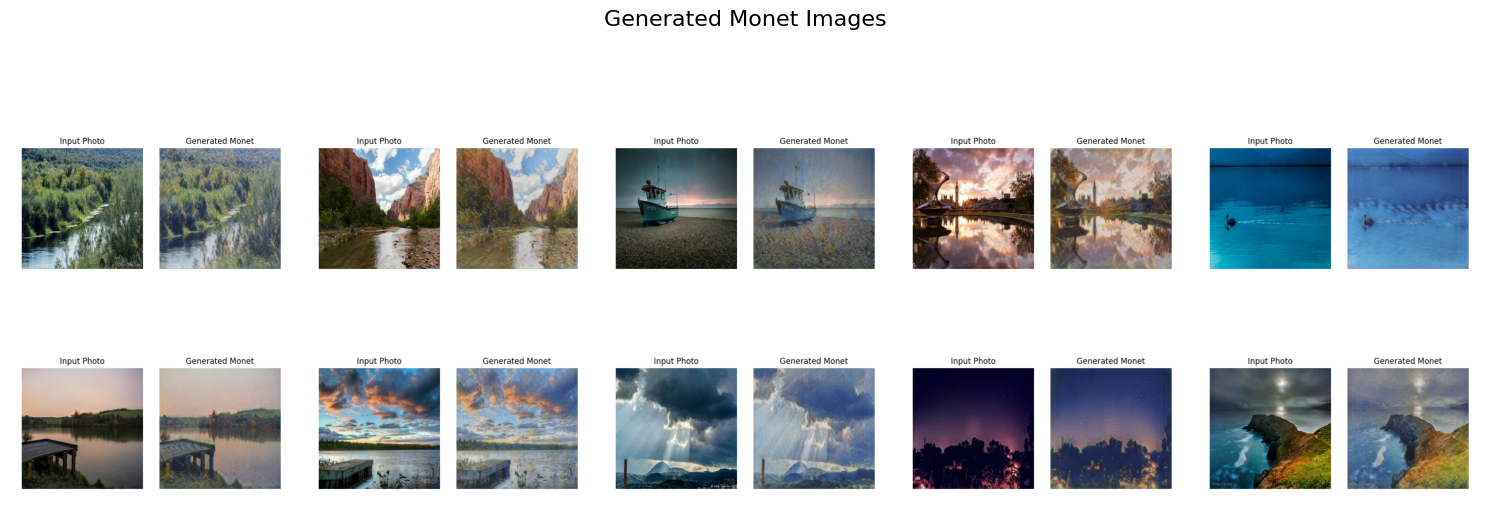

In [50]:
output_images = load_images_from_directory('./outputs', prefix="epoch_100", count=10)
display_image_grid(output_images)

Saving the models

In [53]:
G_photo_to_monet.save("saved_models/G_photo_to_monet.keras")
G_monet_to_photo.save("saved_models/G_monet_to_photo.keras")



In [11]:
import os

output_dir = "monet_jpg_outputs"
os.makedirs(output_dir, exist_ok=True)


In [2]:
from tensorflow.keras.models import load_model

G_photo_to_monet = load_model("saved_models/G_photo_to_monet.keras")


I0000 00:00:1744048249.069062  314579 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [9]:
import tensorflow as tf
from PIL import Image

def generate_and_save_images(model, dataset, total_count=7000, save_dir="monet_jpg_outputs"):
    count = 0
    for batch in dataset.unbatch().batch(1):  # Ensure individual images
        if count >= total_count:
            break

        # Generate Monet-style image
        generated = model(batch, training=False)[0]
        image = tf.clip_by_value((generated + 1.0) * 127.5, 0, 255)
        image = tf.cast(image, tf.uint8).numpy()

        # Save as .jpg
        img = Image.fromarray(image)
        img.save(os.path.join(save_dir, f"monet_{count:05d}.jpg"), format="JPEG", quality=95)
        count += 1

        if count % 500 == 0:
            print(f"Saved {count} images...")

    print(f"✅ Done! {count} Monet images saved to {save_dir}")


In [12]:
generate_and_save_images(G_photo_to_monet, photo_ds, total_count=7000)


Saved 500 images...
Saved 1000 images...
Saved 1500 images...
Saved 2000 images...
Saved 2500 images...
Saved 3000 images...
Saved 3500 images...
Saved 4000 images...
Saved 4500 images...
Saved 5000 images...
Saved 5500 images...
Saved 6000 images...
Saved 6500 images...
Saved 7000 images...
✅ Done! 7000 Monet images saved to monet_jpg_outputs


In [13]:
import zipfile

def zip_images_folder(folder="monet_jpg_outputs", output_zip="images.zip"):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=folder)
                zipf.write(file_path, arcname)
    print(f"📦 Zipped into {output_zip}")


In [14]:
zip_images_folder("monet_jpg_outputs", "images.zip")


📦 Zipped into images.zip
